# 回归模型不稳定性

By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie. Algorithms by David Edwards.


Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

回归分析允许我们估计一个函数的系数，该函数近似地关联多个数据集。我们为这个函数假设了一个特定的形式，然后找到适合数据的系数，在假设模型的偏差可以考虑为噪声的情况下工作。

当我们建立这样一个模型时，我们承认它不能完美地预测因变量。在这里，我们想要评估模型的准确性，不是通过它如何解释因变量，而是通过它相对于我们的样本数据有多<i>稳定</i>(即回归系数有多稳定)。毕竟，如果一个模型确实很合适，那么它应该与我们单独建模的两个随机数据集相似。否则，我们不能假定该模型不是我们碰巧选择的特定数据样本的人工制品，或者它将是新数据点的预测。

为了便于说明，我们将在这里使用线性回归，但是同样的考虑适用于所有回归模型。下面，我们定义了一个包装函数，用于“statsmodel”中的线性回归，以便以后使用。

In [1]:
import numpy as np
import pandas as pd
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp

def linreg(X,Y):
    # Running the linear regression
    x = sm.add_constant(X) # Add a row of 1's so that our model has a constant term
    model = regression.linear_model.OLS(Y, x).fit()
    return model.params[0], model.params[1] # Return the coefficients of the linear model

# 有偏差的噪音

我们为数据选择的特定样本会影响生成的模型，不均匀分布的噪声会导致模型不准确。下面我们画的是正态分布，但由于数据点不多，我们得到的是显著的向下偏倚。如果我们进行更多的测量，两个回归系数都将趋近于零。

Slope: 0.009072503822685521 Intercept: -0.4020774408530382


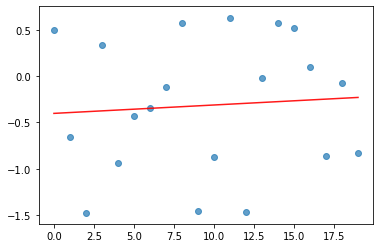

In [2]:
# Draw observations from normal distribution
np.random.seed(107) # Fix seed for random number generation
rand = np.random.randn(20)

# Conduct linear regression on the ordered list of observations
xs = np.arange(20)
a, b = linreg(xs, rand)
print ('Slope:', b, 'Intercept:', a)

# Plot the raw data and the regression line
plt.scatter(xs, rand, alpha=0.7)
Y_hat = xs * b + a
plt.plot(xs, Y_hat, 'r', alpha=0.9);

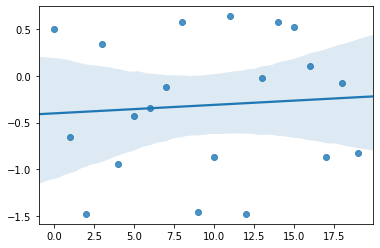

In [3]:
import seaborn

seaborn.regplot(xs, rand)

Slope: -0.0005693423631053347 Intercept: 0.009011767319021813


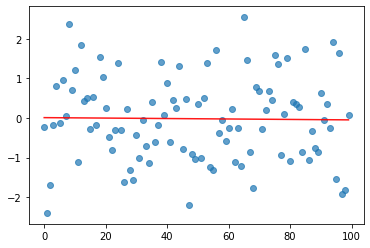

In [4]:
# Draw more observations
rand2 = np.random.randn(100)

# Conduct linear regression on the ordered list of observations
xs2 = np.arange(100)
a2, b2 = linreg(xs2, rand2)
print('Slope:', b2, 'Intercept:', a2) 

# Plot the raw data and the regression line
plt.scatter(xs2, rand2, alpha=0.7)
Y_hat2 = xs2 * b2 + a2
plt.plot(xs2, Y_hat2, 'r', alpha=0.9);

回归分析对异常值非常敏感。有时这些异常值包含信息，在这种情况下，我们希望考虑它们;然而，在上述情况下，它们可能只是随机噪声。虽然我们通常比上面的例子有更多的数据点，但是我们可能会有(例如)几周或几个月的波动，这将显著地改变回归系数。

# 状态变化

状态变化(或结构中断)是指在生成数据的过程中发生了变化，导致未来的样本遵循不同的分布。下面，我们可以看到在2007年底有一个政权的变化，并且将那里的数据分割成一个更好的拟合结果(用红色表示)，而不是对整个数据集的回归(用黄色表示)。在这种情况下，我们的回归模型将不能预测未来的数据点，因为基础系统不再与样本中相同。事实上，回归分析假定误差是不相关的，并且有恒定的方差，但如果发生状态变化，情况往往不是这样。

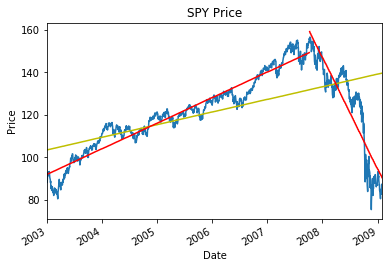

In [6]:
from pandas_datareader import data
start = '2003-01-01'
end = '2009-02-01'
pricing = data.get_data_yahoo('SPY',start,end)['Close']

# Manually set the point where we think a structural break occurs
breakpoint = 1200
xs = np.arange(len(pricing))
xs2 = np.arange(breakpoint)
xs3 = np.arange(len(pricing) - breakpoint)

# Perform linear regressions on the full data set, the data up to the breakpoint, and the data after
a, b = linreg(xs, pricing)
a2, b2 = linreg(xs2, pricing[:breakpoint])
a3, b3 = linreg(xs3, pricing[breakpoint:])

Y_hat = pd.Series(xs * b + a, index=pricing.index)
Y_hat2 = pd.Series(xs2 * b2 + a2, index=pricing.index[:breakpoint])
Y_hat3 = pd.Series(xs3 * b3 + a3, index=pricing.index[breakpoint:])

# Plot the raw data
pricing.plot()
Y_hat.plot(color='y')
Y_hat2.plot(color='r')
Y_hat3.plot(color='r')
plt.title('SPY Price')
plt.ylabel('Price');

当然，我们将数据集分解得越多，我们就越能精确地适应它。重要的是要避免对噪声进行拟合，因为噪声总是波动的，无法预测。我们可以测试是否存在结构性断裂，无论是在我们已经确定的某一点上，还是在一般情况下。下面我们使用一个来自`statsmodels`的测试，它计算在没有断点的情况下观察数据的概率。

In [7]:
stats.diagnostic.breaks_cusumolsresid(
    regression.linear_model.OLS(pricing, sm.add_constant(xs)).fit().resid)[1]

5.713702903517785e-59

# 多重共线性

以上我们只考虑一个因变量对一个独立变量的回归。然而，我们也可以有多个独立变量。如果自变量高度相关，则会导致不稳定性。

假设我们使用两个独立变量，$X_1$和$X_2$，它们高度相关。如果我们加入一个新的观察结果，其中一个解释得比另一个稍微好一些，那么系数可能会发生剧烈的变化。在极端情况下，如果$X_1 = X_2$，则系数的选择将取决于特定的线性回归算法。

下面，我们进行多元线性回归，其中自变量高度相关。如果我们的样本周期是2013-01-01到2015-01-01，那么系数大约是.25和.1。但是，如果我们将这段时间延长到2015-06-01，这些系数将分别变为大约0.18和0.20。

Constant: -16.243603405890553 MLR beta to S&P 500: 0.24924046465077604  MLR beta to MDY 0.09349176682768134


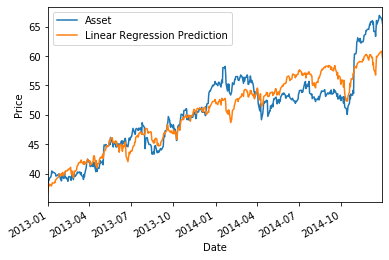

In [8]:
# Get pricing data for two benchmarks (stock indices) and a stock
start = '2013-01-01'
end = '2015-01-01'
b1 = data.get_data_yahoo('SPY', start, end)['Close']
b2 = data.get_data_yahoo('MDY', start, end)['Close']
asset = data.get_data_yahoo('V', start, end)['Close']

mlr = regression.linear_model.OLS(asset, sm.add_constant(np.column_stack((b1, b2)))).fit()
prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2
print('Constant:', mlr.params[0], 'MLR beta to S&P 500:', mlr.params[1], ' MLR beta to MDY', mlr.params[2]) 

# Plot the asset pricing data and the regression model prediction, just for fun
asset.plot()
prediction.plot();
plt.ylabel('Price')
plt.legend(['Asset', 'Linear Regression Prediction']);

我们可以通过计算它们的相关系数来检查我们的自变量是否相关。这个数字总是在-1和1之间，1的值意味着这两个变量是完全相关的。

In [9]:
# Compute Pearson correlation coefficient
sp.stats.pearsonr(b1,b2)[0] # Second return value is p-value

0.9859651923206365